In [24]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [25]:
# load train dataset (todo dataset tem 1309 observações)
df_train = pd.read_csv('datasets/train_titanic.csv')

#### Exibindo os tipos de features, quantidades de observações e features

In [26]:
print(df_train.info())
print(df_train.shape)
#df_train['Cabin']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
(891, 12)


In [27]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Quantos sobreviveram no conjunto de treino

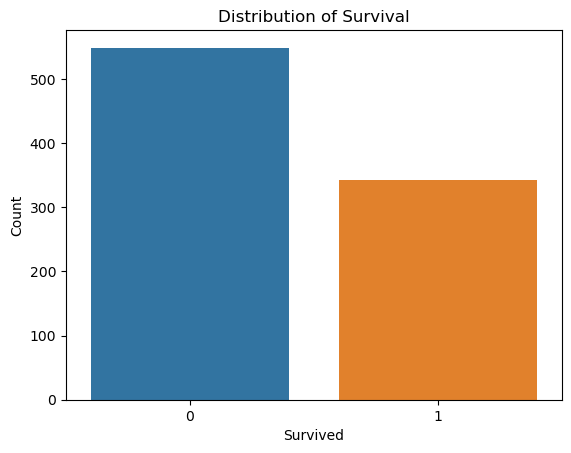

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
## categorical attributes
sns.countplot(data=df_train, x='Survived')
#A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable.

# Add labels and title
plt.xlabel('Survived')
plt.ylabel('Count')
plt.title('Distribution of Survival')

# Show the plot
plt.show()

#### Tarefa 1) Acrescente abaixo células para gerar gráfico de frequência de algumas variáveis categóricas similar ao gráfico acima, para as features PClass, Sibsp, Parch, Embarked (local de embarque). Atenção, as features PClass, Sibsp e Parch, embora numericas (inteiras) são variáveis de contagem com valores discretos podendo ser associado à classes, por isto é chamada categórica aqui

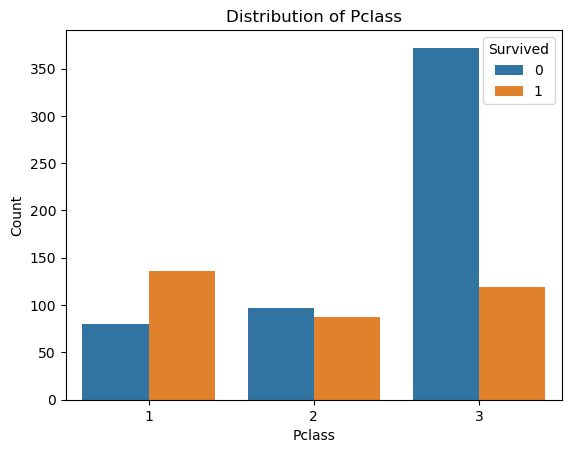

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
## categorical attributes
sns.countplot(data=df_train, x='Pclass', hue='Survived')

# Add labels and title
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.title('Distribution of Pclass')

# Show the plot
plt.show()

##### Ou seja, haviam mais pessoas na terceira classe e depois na primeira classe.

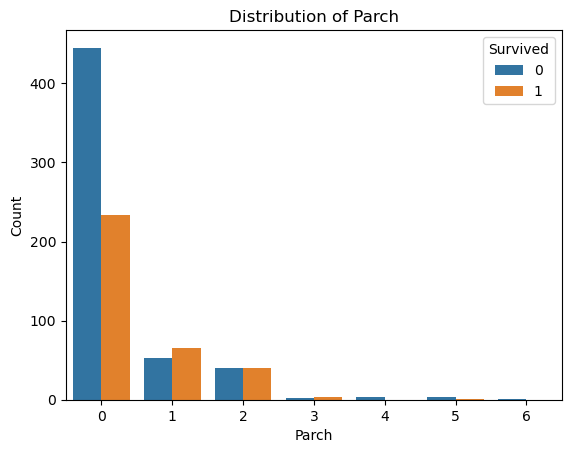

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
## categorical attributes
sns.countplot(data=df_train, x='Parch', hue='Survived')

# Add labels and title
plt.xlabel('Parch')
plt.ylabel('Count')
plt.title('Distribution of Parch')

# Show the plot
plt.show()

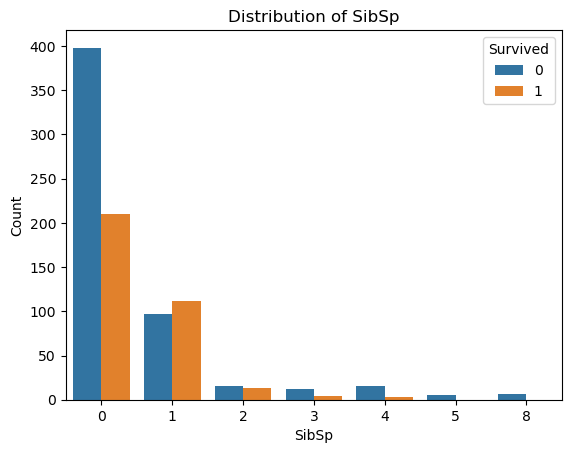

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
## categorical attributes
sns.countplot(data=df_train, x='SibSp', hue='Survived')

# Add labels and title
plt.xlabel('SibSp')
plt.ylabel('Count')
plt.title('Distribution of SibSp')

# Show the plot
plt.show()

##### Como a presença de parentescos/conhecimento entre as pessoas é similar na faixa 0-2 entre SibSp e Parch, poderia-se pensar em Feature Extraction criando uma nova coluna com a soma das duas colunas SibSp e Parch

#### Verificando no conjunto de treino a distribuição entre homens e mulheres que sobreviveram

In [33]:
women = df_train.loc[df_train.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

men = df_train.loc[df_train.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print(f'{sum(women)} Mulheres sobreviventes de {len(women)}: {rate_women}')
print(f'{sum(men)} Homens sobreviventes de {len(men)}: {rate_men}')

233 Mulheres sobreviventes de 314: 0.7420382165605095
109 Homens sobreviventes de 577: 0.18890814558058924


#### Criando uma tabela PIVÔ para verificar a média dos dados numéricos em relação à sobrevivência

In [34]:
pd.pivot_table(df_train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


##### Não há diferença significativa entre as idades médias de sobreviventes e não sobreviventes, contudo pode-se observar se em cada Pclass a concentração de idades e tentar categorizar e também a distribuição de idades de sobreviventes por sexo

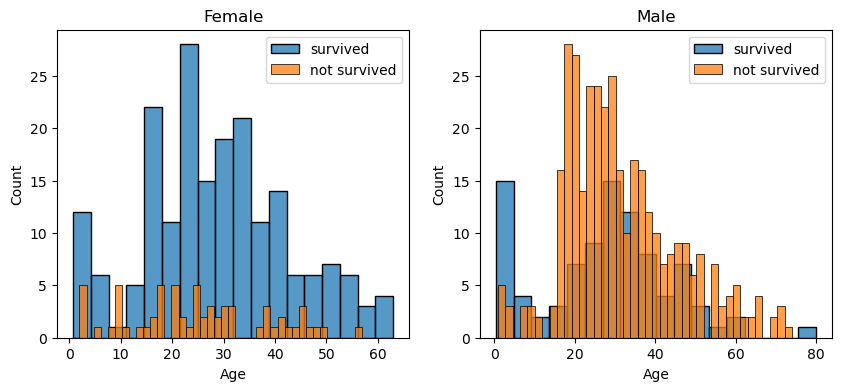

In [35]:
import matplotlib.pyplot as plt
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))

women = df_train.loc[df_train.Sex == 'female']
men = df_train.loc[df_train.Sex == 'male']

ax = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.histplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.histplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

##### Homens entre 18-30 maiores chances, mulheres um pouco menos 14-40 mais chances. Homens entre 5-18 poucas chances de sobrevivência, o que não é verdade para mulheres. Em ambos os casos bebês tem altas chances

#### Quais são suas análises a partir da tabela acima?

#### Verificando a DISTRIBUIÇÃO de idades no conjunto de treino. Verificamos que é uma distribuição quase NORMAL

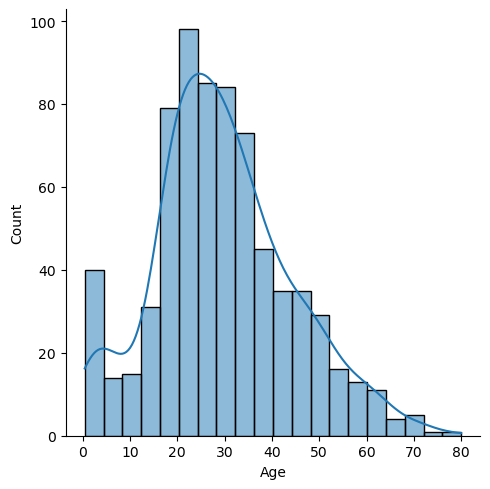

In [36]:
sns.displot(df_train['Age'], kde='True')

##### Já a coluna Fare (tarifa) não possui aspecto de dist normal. É natural pois a maioria está na terceira classe com tarifas mais baixas. Na transformação de dados o ideal é manter a distribuição original dos dados. Se necessário, usar padronização minmax, para trazer a escala para a mesma das idades e das demais colunas

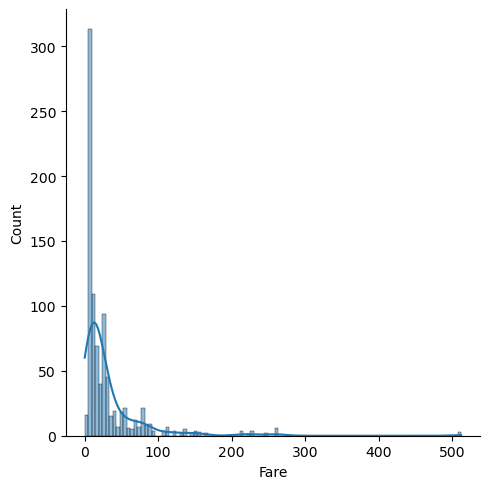

In [79]:
sns.displot(df_train['Fare'], kde='True')

##### Vamos verificar a relação de idades de acordo com as classes no navio entre sobreviventes e não sobreviventes. Vamos ver isto de duas formas, com um barplot e com algo mais próximo a um histograma

<Axes: xlabel='Survived', ylabel='Age'>

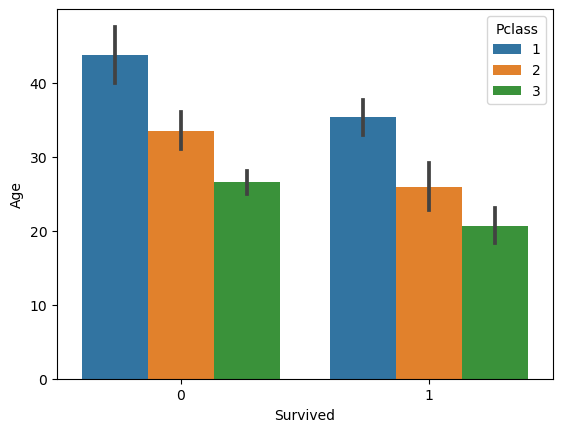

In [13]:
sns.barplot(data=df_train, x='Survived', y='Age', hue='Pclass')

#### Este gráfico pode estar incorreto, pois precisamos ver se há dados faltantes de idade. Caso haja, podemos estabelecer algum critério de preenchimento, como a média das idades

In [41]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [42]:
# Preencher com a idade média
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].mean())

<Axes: xlabel='Survived', ylabel='Age'>

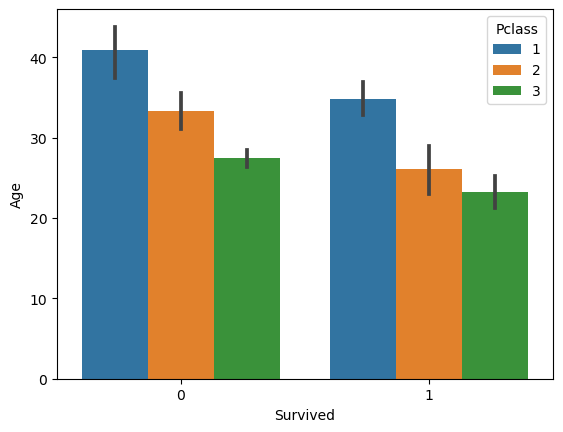

In [43]:
sns.barplot(data=df_train, x='Survived', y='Age', hue='Pclass')

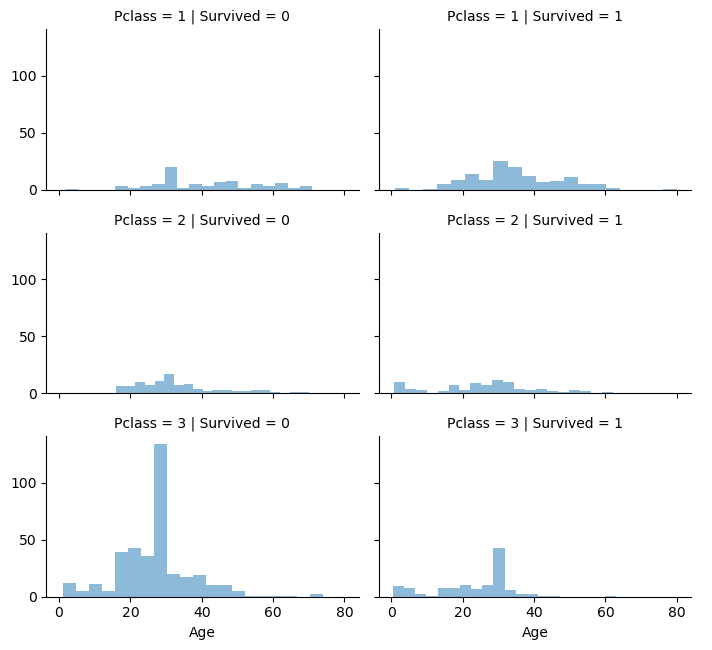

In [44]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

#### Vamos criar um gráfico de barras para entender a distribuição de sobreviventes e não sobreviventes de acordo com a classe e o valor da taxa média

<Axes: xlabel='Survived', ylabel='Fare'>

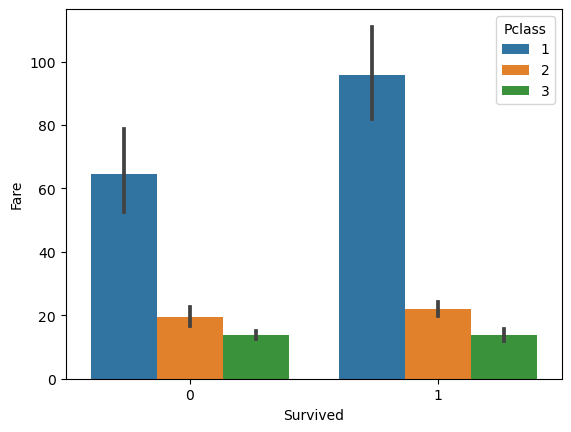

In [45]:
sns.barplot(data=df_train, x='Survived', y='Fare', hue='Pclass')

#### Será que a idade é uma boa feature decisória? E o valor da passagem? Vamos procurar identificar as correlações de Pearson das features numéricas com a variável target

In [46]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C


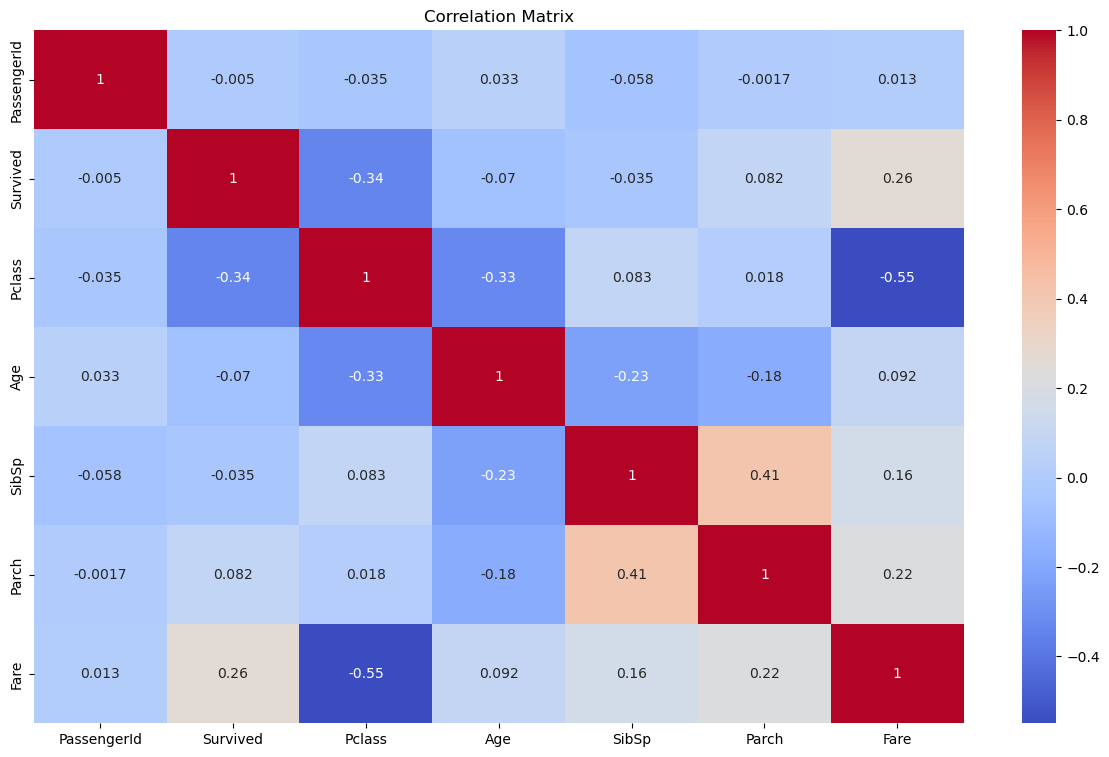

In [47]:
# Calculate correlation matrix for numeric columns only
df_corr = df_train.copy()
df_corr = df_corr.drop(columns={'Name','Sex','Ticket','Cabin','Embarked'})
corr = df_corr.corr(method='pearson', min_periods=1)

# Plot the correlation matrix
plt.figure(figsize=(15, 9))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

#### Escolha 1) classe, sexo, número de parentes sanguíneos e não sanguíneos

In [53]:
df_test = pd.read_csv('datasets/test_titanic.csv')
features_1 = ["Pclass", "Sex", "SibSp", "Parch"] # exemplo de subconjunto de features
# pclass	Ticket class	1 = 1st (upper), 2 = 2nd (middle), 3 = 3rd (lower)
# sibsp: # of siblings The dataset defines family relations in this way... 
# Sibling = brother, sister, stepbrother, stepsister (irmão, irmã, meio-irmão, meio-irmã)
#Spouse = husband, wife (mistresses and fiancés were ignored) (marido, esposa)
# parch: # of parents / children aboard the Titanic (pai, mãe, filha, filho, enteada, enteado). Crianças viajando com babás não foram consideradas aqui	                                                             


##### Unindo SibSp e Parch nos datasets de treino e teste, na coluna RELATIVES (parentes) e acrescentando uma coluna binária not_alone para indicar se viaja sozinho

In [54]:
data = [df_train, df_test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
df_train['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

##### Conferindo a quantidade de parentes total com a sobrevivência. Vemos que de 1 a 3 tem maior probabilidade de sobreviver. Menor que 1 e acima de 4 menor (exceção para 6)

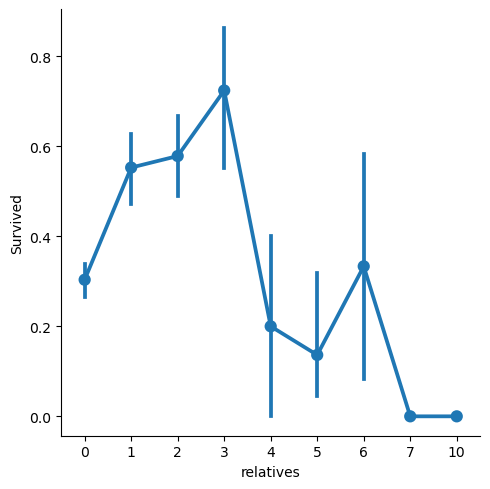

In [78]:
sns.catplot(data=df_train, x='relatives',y='Survived', kind="point")


In [55]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,relatives,not_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,3,0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,0,1


#### Removendo a identificação da cabine (Cabin), o Ticket, o nome da pessoa (Name) e a coluna binária target (Survived) do dataset de treino. A serie target é a coluna Survived

In [57]:
data, target = df_train.drop(columns = {'Survived','Name', 'Cabin', 'Ticket'}), df_train['Survived']

In [58]:
features_1 = ["Pclass", "Sex", "relatives", "not_alone"] # exemplo de subconjunto de features após feature extraction e feature creation

#### Necessário encoder da feature Sex

In [59]:
X = pd.get_dummies(data[features_1]) #similar to one_hot_encoding (return a df)
X

,Pclass,relatives,not_alone,Sex_female,Sex_male
0,3,1,0,0,1
1,1,1,0,1,0
2,3,0,1,1,0
3,1,1,0,1,0
4,3,0,1,0,1
...,...,...,...,...,...
886,2,0,1,0,1
887,1,0,1,1,0
888,3,3,0,1,0
889,1,0,1,0,1


#### Vamos testar estas features com o KNN

#### Vamos criar uma função que recebe o modelo/algoritmo, separa o conjunto de treino em treino limitado/validação e obtém a acurácia de validação e depois roda a validação cruzada e obtém a acurácia média e o desvio padrão. O objetivo é verificar se as duas métricas são semelhantes (com dados novos da CV), para diferentes modelos ML de classificação

In [82]:
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
def classify(model, feature_vector):
    X_train, X_test, y_train, y_test = train_test_split(feature_vector, target, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    print("Accuracy full validation set: %0.2f" % model.score(X_test, y_test))
    
    score = cross_val_score(model, feature_vector, target, cv=10, scoring='accuracy')
    print("Mean Accuracy CV: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

In [99]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
classify(knn_model, X)

Accuracy full validation set: 0.77
Mean Accuracy CV: 0.80 (+/- 0.05)


#### Tarefa 2) Repetir a célula acima para os algoritmos classificadores do sklearn Regressão Logística (LogisticRegression), Árvore de Decisão (DecisionTree), Floresta Aleatória (RandomFlorest), ExtraTreeClassifier, XGBClassifier, CatBoostClassifier. Considerar em cada caso os hiperparâmetros default. Por exemplo, no caso acima poderia ser apenas KNeighborsClassifier(). Escolha o modelo final para predição no conjunto de teste com a menor diferença dos resultados acima

In [105]:
from sklearn.linear_model import LogisticRegression
# LR
lr_model = LogisticRegression()
classify(lr_model, X)

Accuracy full validation set: 0.81
Mean Accuracy CV: 0.79 (+/- 0.04)


In [106]:
from sklearn.tree import DecisionTreeClassifier
# DT
tree_model = DecisionTreeClassifier()
classify(tree_model, X)

Accuracy full validation set: 0.80
Mean Accuracy CV: 0.79 (+/- 0.07)


In [108]:
from sklearn.ensemble import RandomForestClassifier
#RF
rf_model = RandomForestClassifier()
classify(rf_model, X)

Accuracy full validation set: 0.80
Mean Accuracy CV: 0.79 (+/- 0.06)


In [112]:
from sklearn.tree import ExtraTreeClassifier
#ET
et_model = ExtraTreeClassifier()
classify(et_model, X)

Accuracy full validation set: 0.81
Mean Accuracy CV: 0.79 (+/- 0.07)


In [114]:
from sklearn.ensemble import GradientBoostingClassifier
#GB
gb_model = GradientBoostingClassifier()
classify(gb_model, X)

Accuracy full validation set: 0.81
Mean Accuracy CV: 0.80 (+/- 0.07)


In [115]:
from xgboost import XGBClassifier
#XGB
xgb_model = XGBClassifier()
classify(xgb_model,X)

Accuracy full validation set: 0.80
Mean Accuracy CV: 0.79 (+/- 0.06)


In [116]:
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/d6/9e/1cc092730d02e133e48874c112e5a498679ae95c98dd95cb329589d616d4/catboost-1.2.7-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/101.8 MB ? eta -:--:--
   ---------------------------------------- 0.4/101.8 MB 9.1 MB/s eta 0:00:12
   ---------------------------------------- 0.5/101.8 MB 8.6 MB/s eta 0:00:12
   ---------------------------------------- 1.0/101.8 MB 8.3 MB/s eta 0:00:13
    --------------------------------------- 1.5/101.8 MB 7.9 MB/s eta 0:00:13
    --------------------------------------- 1.9/101.8 MB 8.3 MB/s eta 0:00:13
    --------------------------------------- 2.4/101.8 MB 8.6 MB/s eta 0:00:12
   - -------------------------------------- 2.9/101

In [117]:
from catboost import CatBoostClassifier

#CB
cb_model = CatBoostClassifier()
classify(cb_model,X)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216 from C header, got 232 from PyObject


Learning rate set to 0.008417
0:	learn: 0.6879361	total: 140ms	remaining: 2m 19s
1:	learn: 0.6830757	total: 141ms	remaining: 1m 10s
2:	learn: 0.6780381	total: 142ms	remaining: 47.3s
3:	learn: 0.6729400	total: 144ms	remaining: 35.8s
4:	learn: 0.6682699	total: 145ms	remaining: 28.8s
5:	learn: 0.6646328	total: 146ms	remaining: 24.2s
6:	learn: 0.6600883	total: 147ms	remaining: 20.9s
7:	learn: 0.6570032	total: 149ms	remaining: 18.4s
8:	learn: 0.6526157	total: 150ms	remaining: 16.5s
9:	learn: 0.6482643	total: 152ms	remaining: 15s
10:	learn: 0.6442026	total: 153ms	remaining: 13.7s
11:	learn: 0.6402253	total: 154ms	remaining: 12.7s
12:	learn: 0.6363359	total: 156ms	remaining: 11.8s
13:	learn: 0.6324927	total: 157ms	remaining: 11s
14:	learn: 0.6287379	total: 158ms	remaining: 10.4s
15:	learn: 0.6249791	total: 159ms	remaining: 9.79s
16:	learn: 0.6215978	total: 161ms	remaining: 9.28s
17:	learn: 0.6193508	total: 161ms	remaining: 8.81s
18:	learn: 0.6170119	total: 163ms	remaining: 8.4s
19:	learn: 0.6

In [121]:
from sklearn.naive_bayes import GaussianNB

#CB
nb_model = GaussianNB()
classify(nb_model,X)

Accuracy full validation set: 0.80
Mean Accuracy CV: 0.79 (+/- 0.05)


In [62]:
X_test = pd.get_dummies(df_test[features_1])

#Exemplo, se fosse o KNN o melhor acima:
knn_model.fit(X,target)
y_pred = knn_model.predict(X_test)

# salvar para upload em competições como Kaggle em que o conjunto de teste não possui coluna target
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_pred})
output.to_csv('mypredictions.csv', index=False)
print("Submissão salva!")
# https://www.kaggle.com/code/alexisbcook/titanic-tutorial

Submissão salva!


In [63]:

df_full = pd.read_csv('datasets/gender_submission.csv') 
#df_full.head()
target_test = df_full['Survived']
target_test



0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64

In [64]:
from sklearn.metrics import classification_report
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       266
           1       0.88      0.91      0.90       152

    accuracy                           0.92       418
   macro avg       0.91      0.92      0.92       418
weighted avg       0.92      0.92      0.92       418



##### macro avg é a média aritmética daquela métrica para todas as classes. weighted avg é a média ponderada daquela métrica considerando os suportes (quantidade de amostras por classe),ou seja quanto mais amostras, maior o peso

In [69]:
knn_report = pd.DataFrame(classification_report(y_true = target_test, y_pred = y_pred, output_dict=True)).transpose()
knn_report.to_csv('knn_testset_report.csv', index= True)

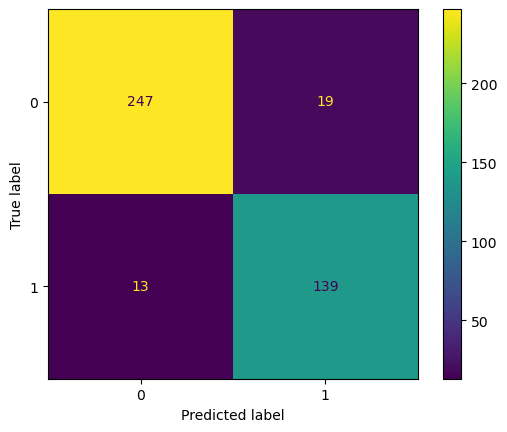

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_model.classes_)
disp.plot()

##### Vamos incluir a idade e a tarifa tal como estão como features

In [94]:
features_2 = ["Pclass", "Sex", "relatives", "not_alone", "Age", "Fare"] # exemplo de subconjunto de features após feature extraction e feature creation
X_2 = pd.get_dummies(data[features_2]) #similar to one_hot_encoding (return a df)

In [95]:
# KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
classify(knn_model, X_2)

Accuracy full validation set: 0.70
Mean Accuracy CV: 0.73 (+/- 0.07)


##### Aplicando MinMaxScaler em todas as features_2

In [96]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(X_2)

In [97]:
# KNN
knn_model_2 = KNeighborsClassifier(n_neighbors=5)
classify(knn_model_2, data_scaled)

Accuracy full validation set: 0.80
Mean Accuracy CV: 0.82 (+/- 0.11)


In [118]:
from catboost import CatBoostClassifier

#CB
cb_model_2 = CatBoostClassifier()
classify(cb_model_2, data_scaled)

Learning rate set to 0.008417
0:	learn: 0.6868880	total: 4.51ms	remaining: 4.51s
1:	learn: 0.6815050	total: 6.75ms	remaining: 3.37s
2:	learn: 0.6767871	total: 10.4ms	remaining: 3.45s
3:	learn: 0.6719250	total: 12.3ms	remaining: 3.07s
4:	learn: 0.6663297	total: 14.9ms	remaining: 2.96s
5:	learn: 0.6608474	total: 17.4ms	remaining: 2.88s
6:	learn: 0.6550444	total: 20.5ms	remaining: 2.91s
7:	learn: 0.6503568	total: 23.5ms	remaining: 2.92s
8:	learn: 0.6459055	total: 26.6ms	remaining: 2.93s
9:	learn: 0.6406133	total: 29.7ms	remaining: 2.94s
10:	learn: 0.6357332	total: 32.6ms	remaining: 2.93s
11:	learn: 0.6306082	total: 36.8ms	remaining: 3.03s
12:	learn: 0.6255798	total: 39.5ms	remaining: 3s
13:	learn: 0.6207152	total: 42.5ms	remaining: 2.99s
14:	learn: 0.6162344	total: 45.3ms	remaining: 2.98s
15:	learn: 0.6120696	total: 47.3ms	remaining: 2.91s
16:	learn: 0.6082860	total: 49.8ms	remaining: 2.88s
17:	learn: 0.6045249	total: 52.1ms	remaining: 2.84s
18:	learn: 0.6010292	total: 54.1ms	remaining: 2